# Demo: An Introduction to Multigrid Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
import scipy.linalg
import time
import sys

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
# Update 07/18/22: got retina working with updates thanks to 
# https://stackoverflow.com/questions/54312924/what-is-matplotlibs-retina-display-mode
%matplotlib inline
%config InlineBackend.figure_format='retina'

In this demo, we investigate multigrid methods, which are simple but effective modifications of the classical Jacobi iteration procedure for solving linear elliptic BVPs. Multigrid methods produce more accurate results than Jacobi iteration in less time, without requiring much sophisticated mathematics or programming. The name "multigrid" arises because such methods work by solving related problems on grids of different resolution, patching the computations together to rapidly generate a good approximation for the solution to our BVP.

I have endeavoured to make my simple implementation of multigrid clear and readable. For this purpose I have found the networkX library extremely useful. NetworkX has helped to organize my computations using (admittedly quite trivial) graph-theoretic ideas. As a multigrid novice, I don't know if there are better or more standard ways to produce readable multigrid code, and I warmly welcome any comments in this regard (adam.morgan@mail.utoronto.ca). 

Our discussion is a bit lean on theory, and I encourage the reader to consult the references below for more details.

## Suggested References
- William L. Briggs, Van Emden Henson, \& Steve F. McCormick, *A Multigrid Tutorial*, second edition, SIAM, 2000




- Ru Huang, Ruipeng Li, \& Yuanzhe Xi, "Learning optimal multigrid smoothers via neural networks", Conference on Uncertainty in Artificial Intelligence, July 2021. Available online at https://www.osti.gov/servlets/purl/1811218 




- Randall J. LeVeque, *Finite Difference Methods for Ordinary and Partial Differential Equations: Steady-State and Time-Dependent Problems*, SIAM, 2007 




- Harvard Lomax, Thomas H. Pulliam, \& David W. Zingg, *Fundamentals of Computational Fluid Dynamics*, Springer, 2001




- Holger Wendland, *Numerical Linear Algebra: An Introduction*, Cambridge Univ. Press, 2017




- Chao-Yuan Wu et al., "A Multigrid Method for Efficiently Training Video Models", Proc. IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), June 2020. Available online at https://openaccess.thecvf.com/content_CVPR_2020/papers/Wu_A_Multigrid_Method_for_Efficiently_Training_Video_Models_CVPR_2020_paper.pdf

## Problem Setup

Following LeVeque $\S4.6$, let's work on the one-dimensional boundary value problem below:

\begin{equation}
\left\{
\begin{aligned}
\partial_{x}^2u(x) &= f(x) \doteq -20 + 60\pi x \cos\left(20\pi x^3\right) - \frac12\left(60\pi x^2\right)^2\sin\left(20\pi x^3\right) \quad \forall \ x\in (0,1),
\\ \\ 
u(0) &= 1,
\\ \\ 
u(1) &= 3. 
\end{aligned}
\right.
\end{equation}

This problem admits the exact solution 
$$
u_{\text{exact}}(x)  = 1+12x-10x^2 +\frac12 \sin\left(20\pi x^3\right). 
$$

Such a problem provides an interesting test case because $u_{\text{exact}}$ includes prominent low-frequency and high-frequency features, as a plot demonstrates: 

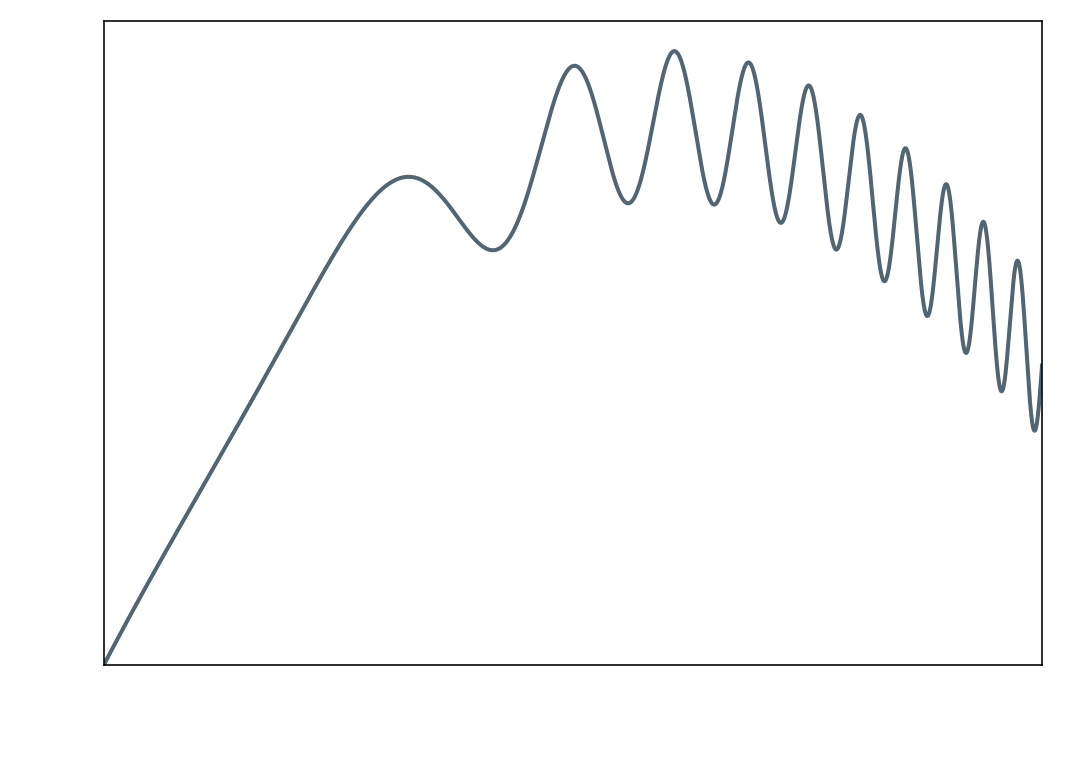

In [17]:
L = 1. # domain length
x = np.linspace(0, 1, num = 1+int(1e5) , endpoint = True) # number of grid points for plot
#(we use a lot more points here than we would in numerical practice, just to get the pic
# looking good)
y = 20.*np.pi*x**3
v_exact = 1.+12.*x-10.*(x**2) +0.5*np.sin(y)

fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(x, v_exact, color='xkcd:slate', linestyle='solid', linewidth=2)

plt.xlim([0., 1.])
plt.ylim([0.999, 5.3])

textcolor='w'

plt.xlabel(r"$x$", fontsize=26, color = textcolor)
plt.ylabel(r"$u_{\mathrm{exact}}(x)$", fontsize=26, color = textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=16, rotation=0, color = textcolor)
plt.tick_params(axis='y', which='both', right='off', color = textcolor)
plt.yticks(fontsize=16, rotation=0, color = textcolor)
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.tight_layout()

fig.set_size_inches(8, 6)

plt.show()

The left side of the picture is dominated by low-frequency (slowly varying) components of $u_{\text{exact}}$, while the right side of the picture is dominated by high-frequnecy (rapidly varying) components of $u_{\text{exact}}$. 

We want a fast, accurate numerical solver for the simple linear BVP above. Pick $K>0$ and discretize $[0,1]$ into a lattice with $N_{x} = 2^{K}+1$ points $x_{0}, x_{1},... x_{2^{K}}$. The lattice spacing is uniform and equal to 
$$
h = 2^{-K}. 
$$
We then approximate the differential operator $\partial_{x}^2$ using second-order centred finite differences:  
$$
\left(\partial_{x}^2u\right)\left(x_{j}\right)\approx \frac{1}{h^2}\left(u_{j-1}-2u_{j}+u_{j+1}\right), \quad \text{where} \quad u_{j} = u\left(x_{j}\right). 
$$
This transform the BVP into a system of linear algebraic equations
$$
Au_{h} = f
$$
where $u_{h}\in \mathbf{R}^{N_{x}}$ is the unknown, $A\in \mathbf{R}^{N_{x}\times N_{x}}$ is the discrete differential operator, and $f\in \mathbf{R}^{N_{x}}$; note that the first and last rows of $A$ and the first and last entries of $f$ enforce the boundary conditions. 

Defining our lattice, $A$, and $f$ in Python is not so bad: 

In [18]:
L = 1. 
h = 2**-8
Nx = 1 + int(L/h)

xh = np.linspace(0, 1, num = Nx , endpoint = True)

y = 20.*np.pi*xh**3
f = -20. + 60.*np.pi*xh*np.cos(y)-0.5*((60.*np.pi*xh**2)**2)*np.sin(y)

# Account for boundary stuff
f[0] = 1.
f[-1] = 3.

# recompute v_exact on new grid
v_exact = 1.+12.*xh-10.*(xh**2) +0.5*np.sin(y)

In [19]:
# assemble our differential operator on a grid of size 2^{M}h... this kind of adaptibility is 
# required for our improved multigrid method a bit later. 
def assemble_operator(M, h = 1e-2):
        
    hh = (2**M)*h
    
    Nx = 1 + int(L/hh)

    diag = np.ones(Nx)
    
    r = 1./(hh**2)
    
    diag[1:-1] *= -2.*r
    
    diagu = r*np.append(np.array(0.), np.ones(Nx-2))
    
    diagd = r*np.append(np.ones(Nx-2), 0.)
    
    A = sparse.diags([diagu, diag, diagd], [1, 0, -1])

    return A.tocsr()

## A Bad Numerical Method, or: Iteration Does Not Treat All Frequencies Equally!

Now, we are ready to apply a numerical linear algebra method to solve $Au_{h}=f$, and thereby get an approximate solution to our BVP. Since the problem involves a nice, symmetric, sparse, non-strictly diagonally dominant matrix, Jacobi iteration might do a decent job of quickly generating $u_{h}\approx u_{\mathrm{exact}}$. 

Recall that, for a fixed weight parameter $\omega$, we can express weighted Jacobi iteration as 

$$
u_{h}^{(n+1)} = u_{h}^{(n)} + \omega D^{-1}r^{(n)}
$$

where $r^{(n)}=f-Au_{h}^{(n)}$ is the residual at step $n$, and $D$ is the diagonal part of $A$. 

Here is some simple code for weighted Jacobi iteration. 

In [20]:
def solve_jacobi(A, b, x0, weight = 1., max_its = 1e2, no_converge = True): # default to weight=1 which is vanilla Jacobi.
    # A must be a sparse matrix object (csr_matrix), and b, x0 must be numpy arrays. 
    
    # hyperparams related to convergence first:
    tol = 1e-10
        
    # now start to construct matrices relevant for iteration. 
    d = A.diagonal()
        
    d_inv = 1./d
            
    D_inv = sparse.diags([d_inv], [0], shape=A.shape)
                         
    LplusU =  -1.*(sparse.triu(A,1) + sparse.tril(A,-1))
        
    #R = (1.-weight)*np.eye(A.shape[0]) +  weight*(D_inv @ LplusU)# iteration matrix .
    # Note: the functions triu and tril extract entries above or below a set diagonal (inclusive),
    # resp. 

    r = b - A @ x0 # residual at current step
    
    r = np.ravel(r) # extra safety factor for sizing... if you're dealing with 
    # A built partially or in the whole by the sparse matrix package, some subtle
    # array size issues come up, and ravel fixes them nicely. 
    
    speed_flag = 1. # difference between past two iterates, the smallness of which is used 
    # as a stopping criterion. Start it large to get iteration going

    cnt = 0 # iteration counter 
    
    while speed_flag >= tol and cnt < max_its: 
        # stop iteration if consecutive guesses are close or we
        # exceed maximum number of iterations
        
        x = x0 + weight*(D_inv.dot(r))
        
        r = b - A.dot(x)
        
        r = np.ravel(r)
        
        if no_converge == True: # this is the case where we don't want to converge ie. just
            # want to iterate for max_its
            
            speed_flag = 1
            
        else:
        
            speed_flag = np.linalg.norm(x-x0)
        
        x0 = x
                
        cnt += 1
        
    return x, cnt 

We can test out our Jacobi solver on the model problem. The default number of iterations is $\leq 10^{3}$, but you can play with this parameter easily. Additionally, we set the weight parameter to $\frac{2}{3}$ since this turns out to be "optimal" in a certain sense I won't discuss here, but you can change this as well if you like. 

In [37]:
start=time.time()
max_its = 1e3
guess = 1.+2.*xh # simple guess that satisfies BCs
v_jac = solve_jacobi(assemble_operator(0, h=h), f, guess, weight=2./3., max_its=max_its, no_converge=True)[0]
end=time.time()
runtime=end-start
print('Weighted Jacobi runtime = %.4f s' % runtime)

Weighted Jacobi runtime = 0.0298 s


Let's have a look at the error in this approximation:  

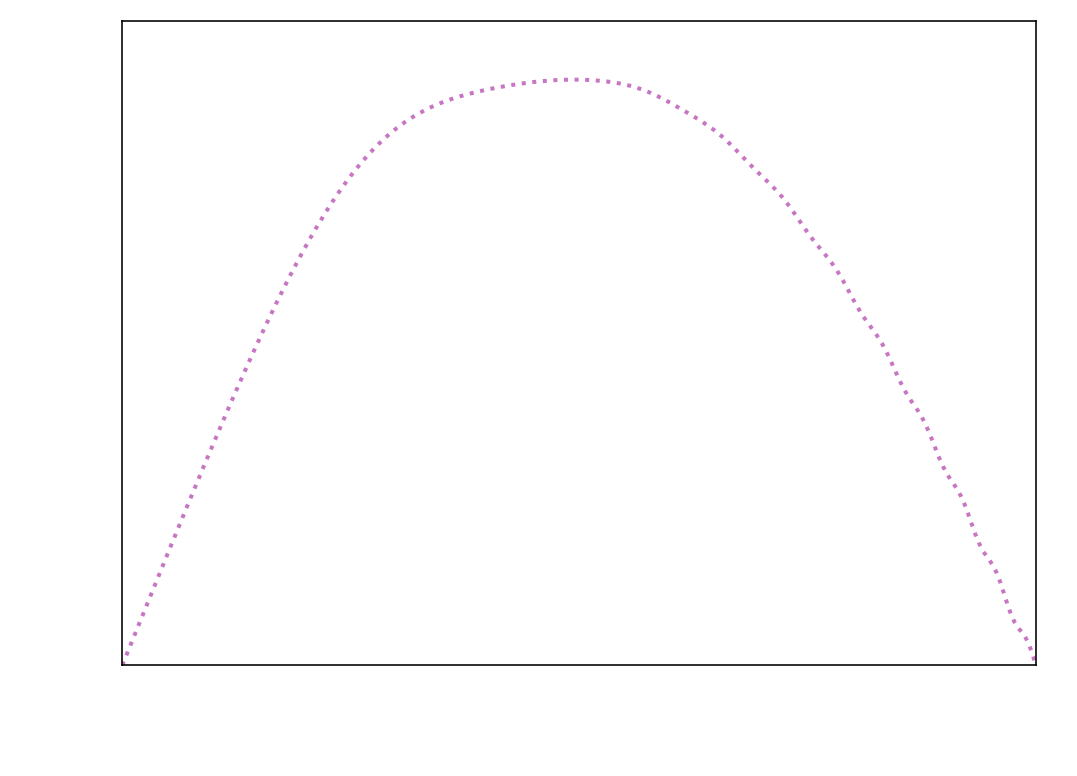

In [38]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(xh, np.abs(v_jac-v_exact), color='xkcd:orchid', linestyle='dotted', linewidth=2)

plt.xlim([0., 1.])
plt.ylim([-0.0001, 1.1*np.amax(np.abs(v_jac-v_exact))])

textcolor='w'

plt.xlabel(r"$x$", fontsize=26, color = textcolor)
plt.ylabel(r"Absolute Error", fontsize=26, color = textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=16, rotation=0, color = textcolor)
plt.tick_params(axis='y', which='both', right='off', color = textcolor)
plt.yticks(fontsize=16, rotation=0, color = textcolor)
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.tight_layout()

fig.set_size_inches(8, 6)

plt.show()

For $<10^{3}$ iterations, the weighted Jacobi method gives a poor answer, with $\mathcal{O}(1)$ absolute error! One must set the maximum iteration number to $10^{5}$ to see $\mathcal{O}\left(10^{-2}\right)$ errors, which takes about $4$s. So, weighted Jacobi iteration is too slow to be a competitive solver for this problem. 

Take a minute and play around with the maximum iteration number in the above coe blocks. Set $\texttt{max_its}$ to be very small, say $<15$. You'll notice that the error includes more high-frequency pieces. These high-frequency pieces mostly disappear by the hundreth iteration, as you can easily check yourself. This indicates that Jacobi iteration is not so bad at killing the high-frequency components of error (they appear to the naked eye to be gone after $\mathcal{O}\left(100\right)$ iterations), but it really struggles to kill the low-frequency component of the error (the error after $10^3$ iterations looks like a single half-period of sine). So, there is definitely some discrepancy between how low and high frequency component of error behave under Jacobi iteration. 

The empirical observations in the above paragraph can be confirmed analytically via an eigenvalue analysis of the Jacobi iteration matrix, see LeVeque $\S 4.6$. The bottom line is that Jacobi iteration is decent at getting rid of high-frequency errors, but abominable at getting rid of low-frequency errors. Said differently, Jacobi iteration is a smoothing procedure, but once it smooths out every rough patch it really slows down. At this point, you should feel a short of tempered optimism in your heart: Jacobi is not very good, but it is at least simple and capable of handling very particular types of errors, suggesting that an easy modification of Jacobi should give us a much better answer. 

## Basic Ideas of Multigrid

Multigrid methods are clever ways to take advantage of all the good parts of Jacobi iteration, while simultaneously recitfying all the bad parts.

The key observation behind multigrid is incredibly simple. Consider a grid on $[0,1]$ with uniform spacing $h=2^{-K}$, and call this grid $\Omega_{h}$. Owing to aliasing, we can only accurately resolve oscillatory functions with frequencies below a certain threshold usually called the Nyquist frequency. Equivalently, signals at the Nyquist frequency are the **highest** frequency signals that can be accurately resolved on our grid. 

The Nyquist frequency on $\Omega_{h}$ is $\frac12 N_{x}$, where $N_{x} = 1 + \frac{1}{h}$. Obviously, then, the Nyquist frequency on $\Omega_{2h}$ is $\frac12 \left(1+\frac{1}{2h}\right)$, which is strictly less than the Nyquist frequency on $\Omega_{h}$. So, the rougher we make our grid, the lower the highest frequency we can possibly resolve. 

Aha! If Jacobi iteration does well on high frequencies, then maybe we can fix its issues with the following procedure: 

1) Perform a fixed, small number $\nu_{1}$ of weighted Jacobi iterations on $Au_{h}=f$ using the *fine grid* $\Omega_{h}$ and any old initial guess to get an approximate solution $u_{\nu_{1}}\approx u_{h}$. This approximation will be poor, but at least the high-frequency components of the error will be gone. 

2) Form the residual $r_{h}=f-Au_{h}$ on the fine grid. 

3) Downsample the residual to a *rough grid* $\Omega_{2h}$ (where we keep only every other grid point on $\Omega_{h}$) to get $r_{2h}$. 

4) Approximate the error on the rough grid $e_{2h}=u_{h}-u_{\nu_{1}}$ by solving the *residual equation*
$$
A_{2h}e_{2h} = r_{2h}
$$
either by using Jacobi with initial guess $e_{2h}=0$, or with a direct method if $2h$ is sufficiently large. Note here that $A_{2h}$ is the second-order centred finite difference approximation to $\partial_{x}^2$ on the lattice $\Omega_{2h}$. Since $\Omega_{2h}$ is a rougher grid, the "high" frequencies on $\Omega_{2h}$ are actually pretty low when viewed from the fine grid $\Omega_{h}$. So, Jacobi iteration on $\Omega_{2h}$ will kill the low-frequency components of our error! 

5) Now, go back up to the fine grid. Upsample $e_{2h}$ to a new signal $e_{h}$ on $\Omega_{h}$ using piecewise linear interpolation. 

6) Iterate $\nu_{2}$ times on $Au_{h}=f$ using the improved initial guess $u_{\nu_{1}}+e_{h}$, which from the above arguments should be very close to $u_{h}$.  

Thus, multigrid takes advantage of basic signal processing to really make Jacobi iteration purr. Note in particular that the algorithm outlined above only requires you to have a working Jacobi iterator, a direct solver that works for small matrices, and functions for upsampling and downsampling. There are no serious software demands! However, in my implementation below, I have found it convenient to use the networkX graph library to help sort out the computations. 

Strictly speaking, the technique I just described is not "the" multigrid method, but only *a* multigrid method; specifically, it is called the *2-level V-cycle* for reasons I'll explain soon. By nesting iterations of certain steps, one can develop more complex multigrid methods. For instance, in the *$N$-level V-cycle* method, one solves and downsamples $N$ times to get to a final rough grid $\Omega_{2^{N}h}$. After the residual equation is solved on the final grid, we iterately move back up the grid hierarchy, using all our previously computed errors recursively to get better and better guesses until we're back at the fine grid. The key is that we always coarsen by factors of $2$ to keep things simple. One could also start from the rough grid and upsample, then do some V-cycles, and this would also count as a perfectly good multigrid method. Below, when we're in the thick of the code, I'll say much more about how to efficiently think about all these different grids and what we use them for. Additionally, the reader looking for deeper discussion/more pseudocode examples may wish to read Briggs et al. Ch. 3. 

Finally, in principle we may also use weighted Gauss-Seidel iteration or any other relaxation-type scheme in place of Jacobi to perform smoothing iterations on each grid. For some recent discussion on the use of neural networks to find "optimal" relaxation schemes for multigrid, see Huang et al. 

## Implementing Multigrid Methods

Our next step is to actually code up some multigrid methods for our simple one-dimensional problem. Perhaps at the expense of brevity, I have tried to make my code as readable as possible, and this motivated me to use the networkX graph computation package, which some readers may not be familiar with. However, networkX is very easy to use, and in my opinion the many features of this package greatly facilitate the production of clean, readable multigrid code. 

Let's start with the easy stuff: the down/up-sampling functions we need to move between different grids. Since consecutive grid sizes always differ by a factor of $2$ (or $\frac12$), this is straightforward (see Briggs et al. p. 34): 

In [8]:
def downsample(uh):

    return uh[0::2]

def upsample(u2h): 
    
    N_coarse = np.size(u2h)   
    
    uh = np.zeros(int(2*N_coarse)-1)
    
    uh[0::2] = u2h
    
    uh[1:-1:2] = 0.5*(u2h[0:-1]+u2h[1:])

    return uh

Note that our down/up-sampling routines are strongly dependent on our grids having $1+2^{K}$ points for some $K$.  

We now draw some pictures to make sure our downsampling and upsampling routines are doing what they should. 

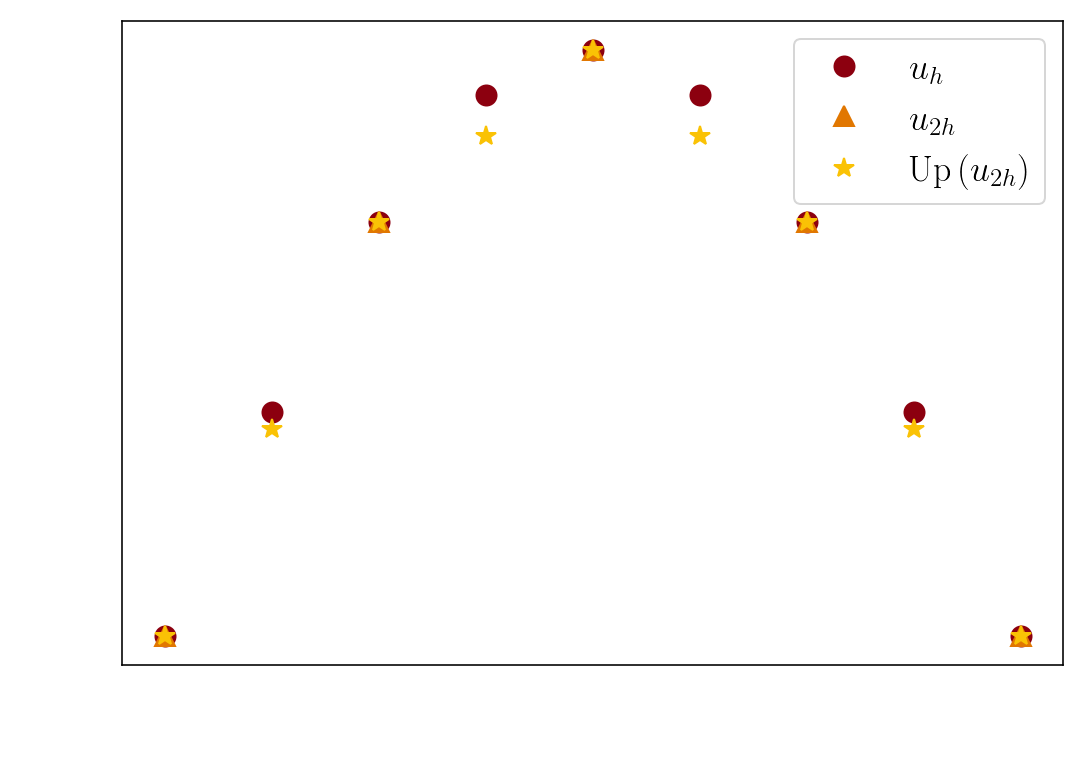

In [9]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

xh = np.linspace(0,1,2**3 + 1)
uh = np.sin(np.pi*xh)
plt.plot(xh,uh, 'o', color = 'xkcd:crimson', label=r"$u_{h}$", markersize=10)
x2h = downsample(xh)
u2h = downsample(uh)
plt.plot(x2h, u2h, '^', color = 'xkcd:pumpkin', label=r"$u_{2h}$",  markersize=10)
uh_new = upsample(u2h)
plt.plot(xh, uh_new, '*', color='xkcd:goldenrod', label=r"$\mathrm{Up}\left(u_{2h}\right)$",  markersize=10)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='best', fontsize='18')

textcolor='w'

plt.xlabel(r"$x$", fontsize=26, color = textcolor)
plt.ylabel(r"y", fontsize=26, color = textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=16, rotation=0, color = textcolor)
plt.tick_params(axis='y', which='both', right='off', color = textcolor)
plt.yticks(fontsize=16, rotation=0, color = textcolor)
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.tight_layout()

fig.set_size_inches(8, 6)

plt.show()

plt.show()

Notice how the upsampled version of $u_{2h}$ is not the same as $u_{h}$. That is, upsampling is only the *right* inverse for upsampling (this is obvious since downsampling is onto but not injective). 

The next order of business is to somehow organize how we're going to move between different grids, and what work needs to be done on each grid. This sort of software logistics is usually focused around a directed graph called the *grid schedule* $G$ for a particular multigrid method. 

$G$ is a directed path graph; that is, it has an initial node, a final node, and no cycles/loops (this does make use of the name "V-cycles" confusing, but it is too late now). Each node carries two attributes: 

1) the "level": this is the number $M$ such that the computation on our node takes place using the grid $\Omega_{2^{M}h}$. For example, on a 2-level $V$-cycle, the initial and final nodes have level 0, and the middle node has level 1. 

2) the "task": this describes what computation will take place on our node. We could either iterate for $\nu_{1}$ steps and downsample, solve the residual equation directly, or upsample an error estimate and iterate with a modified initial guess for $\nu_{2}$ steps. In the code below, these three computations are called "$\texttt{relax_down}$", "$\texttt{solve}$", and "$\texttt{relax_up}$", respecitvely. 

Given a schedule $G$, we start at the initial node, perform the specified task, then move to the next node by following the edge arrows of $G$. At the next node, we perform the specified task and move on again, and the whole procedure repeats until we've run out of nodes and thereby found the approximation to $u_{h}$ we seek.

Strictly speaking, this framework (and my implementation below) would need to be modified for grid schedules that are not V-cycles: simply put, there are more tasks that might need to be done for more complex multigrid methods, especially those schedules that start on a coarse grid and move up. To keep things basic for now, we'll only discuss and implement a multigrid code that works for V-cycles with an arbitrary number of levels. 

We now define grid schedule graphs as networkX $\texttt{DiGraph}$ (directed graph) objects. We start by defining a function that creates a V-cycle with a given number of levels $N$. Remember that each node has two attributes: the coarsening level, and the task to be done on the particular grid at the particular time. Levels are integers and tasks are strings. These attributes are easily assigned to each node using networkX's convenient attiribute functionality. 

For future reference, the V-cycles we present may be drawn and displayed by using the appropriate keyword when the schedule is created. 

In [10]:
# create a function that outputs an N-level V-cycle. Each node is tagged with its coarsening
# level as a node attribute. 
def Vcycle(N, draw = True):

    n_verts = 2*N - 1 # number of vertices

    # create the directed graph, which is simply a one-way directed path graph
    G = nx.path_graph(n_verts, create_using = nx.DiGraph)
    
    # now give each node a coarsening level attribute... the finest
    # grid has m = 0 and nodes on top of the graph, and the coarsest grid
    # has m = N and its single node at the bottom of the graph. The node-to-level
    # correspondence must be inputted as a dict
    
    node_keys = [*range(0, 2*N-1)]
    
    levels_list = [*range(0,N)]+ [*range(N-2,-1, -1)]
    # a simple method for turning two lists into a dict from geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/
    levels = dict(zip(node_keys, levels_list))
    nx.set_node_attributes(G, levels, "levels")
    
    # now prescribe the task attributes at each node
    tasks_list = ['relax_down']*(N-1) + ['solve'] + ['relax_up']*(N-1)  
    tasks = dict(zip(node_keys, tasks_list))
    nx.set_node_attributes(G, tasks, "tasks")
    
    # Now draw the directed graph we've created, if you so desire. 
    if draw == True: 

        centre_node_label = N-1  # corresponding to coarsest grid

        # group nodes by column
        top_nodes = [0, n_verts-1]

        node_tiers = []

        for k in range(0, N):
    
            node_tiers.append([k, n_verts-1-k])

        bottom_nodes = [centre_node_label]

        # set positions of nodes for drawing 
        pos = {n: (N-1, 0) for i, n in enumerate(bottom_nodes)}

        for k in range(0,N):

            pos.update({n: (n, N+1-k) for i, n in enumerate(node_tiers[k])})
    
        options = {
            "font_size": 25,
            "font_color": "xkcd:carnation",
            "node_size": 900,
            "node_color": "xkcd:carnation",
            "edgecolors": "xkcd:carnation",
            "edge_color":"xkcd:dark aqua",
            "linewidths": 4.7,
            "width": 5,
        }

        nx.draw_networkx(G, pos, **options)

        # Set margins for the axes so that nodes aren't clipped
        ax = plt.gca()
        ax.margins(0.20)
        plt.axis("off")
        plt.show()
        
    return G

We now draw the grid schedule for the 2-level V-cycle. This helps visualize what V-cycles actually do (and explains the name), and also helps us confirm that our code is working. 

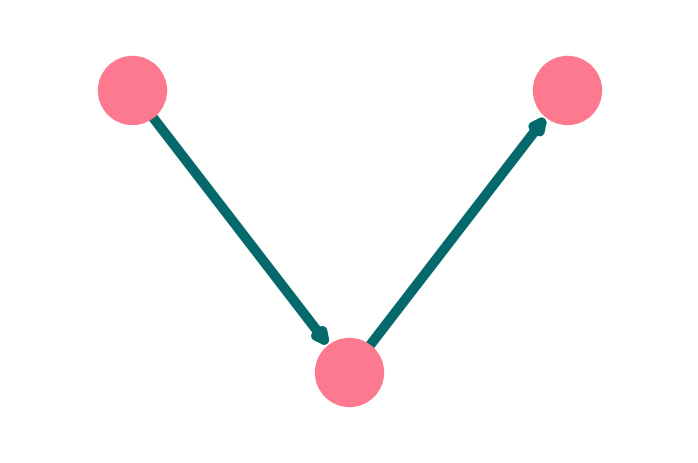

In [11]:
N = 2
G = Vcycle(N, draw=True)

Think of the "level" property as being represented by vertical position, so nodes 0 and 2 (the initial and terminal nodes, resp.) involve the fine grid and node 1 involves the coarse grid. The "task" attribute is not visually represented but is present implicitly: for instance, the way we have described multigrid, there is only one task that can be done when moving from node 1 to node 2 in the following picture. 

TODO: more sophisticated schedules? In particular, FMG?  

We are at last ready to put everything together to create our multigrid solver. We input the matrix $A$ for each grid level as a list of matrices, a right-hand side on the fine grid, a grid schedule, and an initial guess. The number of Jacobi iterations on down and up moves is set at $3$, but this can be changed by modifying appropriate parameters (though $3$ is sufficiently good). 

In [12]:
def multigrid_solve(A_store, f, schedule, v0, nu_down = 3, nu_up = 3):

    nodes = schedule.nodes()
    
    num_nodes = np.size(nodes)

    # initialize
    node = nodes[0]
    
    cnt = 0. 
    
    # create data storage
    v_store = [] 
    
    f_store = [] 
            
    while cnt < num_nodes: 
    
        level = node['levels']
        task = node['tasks']
        
        A = A_store[level] # extract linear operator to be dealt with
                        
        if task == 'relax_down': 
                        
            if level == 0: # initial node in a V-cycle needs to be treated a bit differently
                                      
                guess = v0 
                            
            else:
                
                f = downsample(res) # f gets redefined now! 
                    
                guess = np.zeros_like(f) # after initial node, solve residual equation
                # hence error=0 is a better initial guess!
        
            f_store.append(f)

            v = solve_jacobi(A, f, guess, weight = 2./3., max_its = nu_down, no_converge=True)[0]
                    
            v_store.append(v)
        
            res = f - A @ v
        
        if task == 'solve':
                        
            f = downsample(res)
            
            f_store.append(f)
                        
            v =  sparse.linalg.spsolve(A, f) # can afford a direct solve for a small matrix
                        
            v_store.append(v)
        
        if task == 'relax_up':
            
            f = f_store[level]
                
            v = upsample(v) + v_store[level]
        
            v = solve_jacobi(A, f, v, weight = 2./3., max_its = nu_up, no_converge=True)[0]
    
        cnt += 1
                        
        try:
            
            node = nodes[cnt]
                        
        except KeyError: 
            
            pass
                            
    return v   

Let's start by testing the multigrid solver out on the same fine grid on which we did our earlier (bad!) Jacobi iteration. Our schedule is a simple $6$-level V-cycle. This means the final grid only includes 5 lattice points! 

In [13]:
L = 1. 
h = 2**-8
Nx = int(L/h)+1 # number of grid samples
xh = np.linspace(0, 1, num = Nx , endpoint = True)
y = 20.*np.pi*xh**3
f = -20. + 60.*np.pi*xh*np.cos(y)-0.5*((60.*np.pi*xh**2)**2)*np.sin(y)
# Account for boundary stuff
f[0] = 1.
f[-1] = 3.
N = 7
schedule = Vcycle(N, draw=False)

In [14]:
start=time.time()

A_store = []

for level in range (0,N):
    
    A_store.append(assemble_operator(level, h = h))
    
v_mg = multigrid_solve(A_store, f, schedule, guess, nu_down = 3, nu_up = 3)

end=time.time()

runtime=end-start

print('6-Level V-cycle multigrid runtime = %.4f s' % runtime)

6-Level V-cycle multigrid runtime = 0.0255 s


We find that this particular multigrid method is quite fast, running at comparable speed to $1000$ Jacobi iterations. However, as we see below, it produces a much more accurate solution than Jacobi!

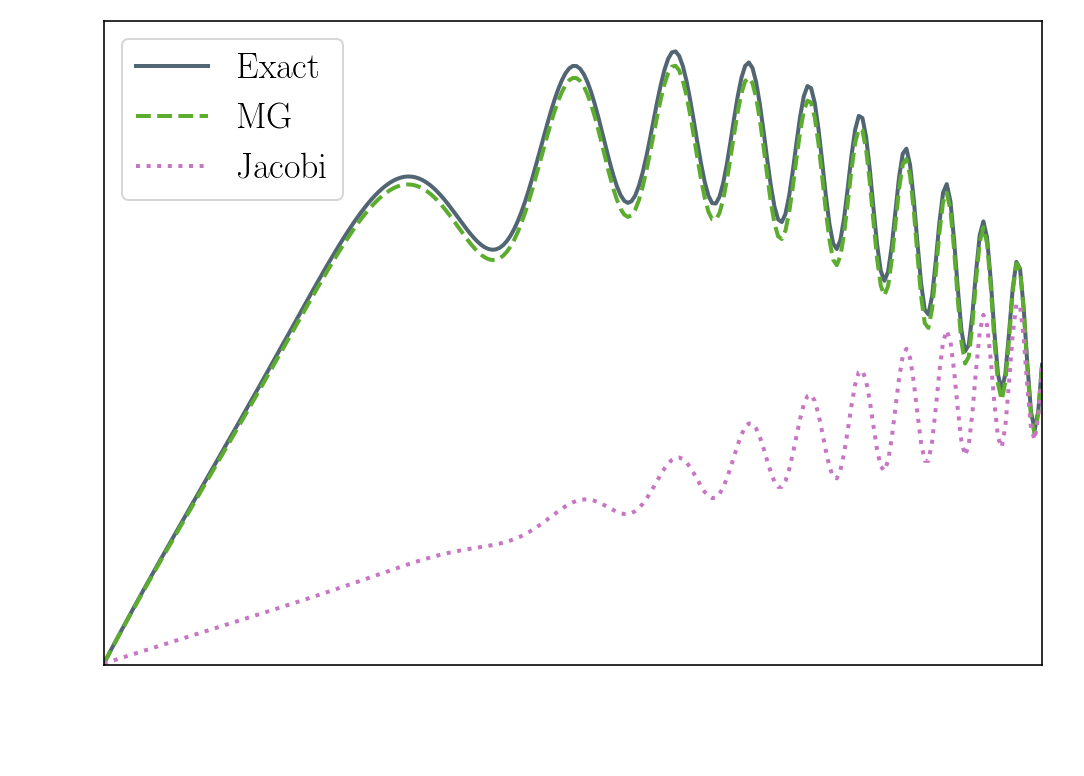

In [15]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(xh, v_exact, color='xkcd:slate', linestyle='solid', label='Exact', linewidth=2)
plt.plot(xh, v_mg, color='xkcd:grass', linestyle='dashed', label='MG', linewidth=2)
plt.plot(xh, v_jac, color='xkcd:orchid', linestyle='dotted', label='Jacobi', linewidth=2)


plt.xlim([0., 1.])
plt.ylim([0.99, 5.3])

plt.legend(loc='best', fontsize='18')

textcolor='w'

plt.xlabel(r"$x$", fontsize=26, color = textcolor)
plt.ylabel(r"$u(x)$", fontsize=26, color = textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=16, rotation=0, color = textcolor)
plt.tick_params(axis='y', which='both', right='off', color = textcolor)
plt.yticks(fontsize=16, rotation=0, color = textcolor)
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.tight_layout()

fig.set_size_inches(8, 6)

plt.show()


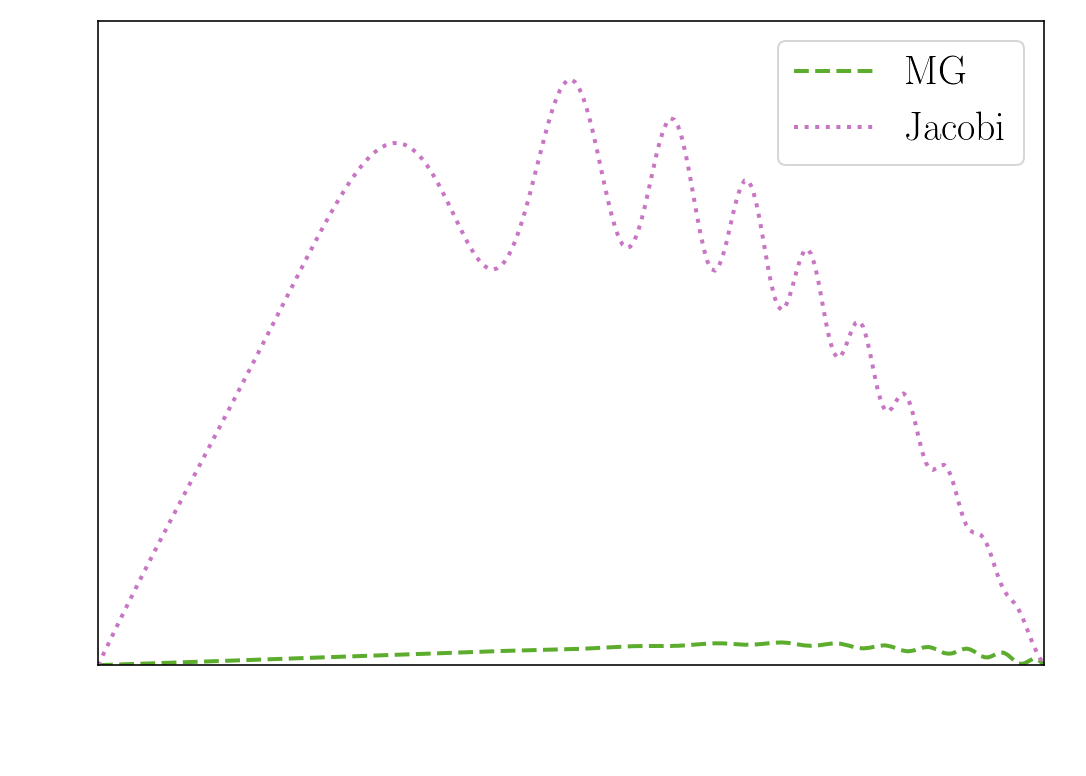

In [16]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(xh, np.abs(v_mg-v_exact), color='xkcd:grass', linestyle='dashed', label='MG', linewidth=2)
plt.plot(xh, np.abs(v_jac-v_exact), color='xkcd:orchid', linestyle='dotted', label='Jacobi', linewidth=2)

plt.xlim([0., 1.])
plt.ylim([-0.0001, 1.1*np.amax(np.abs(v_jac-v_exact))])

plt.legend(loc='best', fontsize='20')

textcolor='w'

plt.xlabel(r"$x$", fontsize=26, color = textcolor)
plt.ylabel(r"Absolute Error", fontsize=26, color = textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=16, rotation=0, color = textcolor)
plt.tick_params(axis='y', which='both', right='off', color = textcolor)
plt.yticks(fontsize=16, rotation=0, color = textcolor)
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.tight_layout()

fig.set_size_inches(8, 6)

plt.show()

So, even a simple V-cycle grid schedule can give an answer that is $100\times$ more accurate than vanilla weighted Jacobi (with a max. iteration number such that the real-time performance of both methods is similar). 

TODO: compare runtime with direct Gaussian elimination

TODO: compare performance and runtime with conjugate gradient

## Final Remarks

-  Multigrid remains an important tool in the 2020s: the references include some very recent papers demonstrating the widespread interest in multigrid methods in modern scientific computing and data science. 

- One can show (see Briggs et al., LeVeque, or Wendland) that, if we're in $1$D and the fine grid includes $N_{x}$ points, the total work required by multigrid is $\mathcal{O}\left(N_{x}\right)$. Thus, in a certain sense, multigrid is "optimal" in that we have only $\mathcal{O}(1)$ work to do for each entry of the vector of unknowns. 

- Suppose you have to solve a large, sparse linear system $Au=f$ that either arises from discretizing a PDE on an unstructured mesh (so "coarsening" as described above is ill-defined and certainly any definition will be yucky), or is not related to a PDE at all (for example, $A$ could the the graph Laplacian, so $Au=f$ is a graph Poisson equation arising from some probability or data science problem): the bottom line is, you are not allowed to talk about an actual grid. Suppose also that you know enough about the structure of $A$ to be pretty sure that a relaxation scheme like Jacobi or Gauss-Seidel is tractable. Of course, I hope to have convinced you by now that multigrid allows relaxation methods to achieve their full potential. How can you accelerate your relaxation procedure using a multigrid-like simplification hierarchy? The answer is to develop a grid-agnostic framework called *algebraic multigrid (AMG)*; the multigrid-with-an-actual-grid framework discussed above is, in contrast, usually called *geometric multigrid*. AMG is a serious topic in and of itself, and elegantly leverages the connections between linear algebra and graph theory to effectively "geometrize" $Au=f$. For an introduction to AMG, see Briggs et al. Ch. 8 